In [1]:
from utils import *

set_cache_dir('pickles/slides2')

ERROR 1: PROJ: proj_create_from_database: Open of /home/arthur/miniforge3/envs/climada_env/share/proj failed


# Introduction to CLIMADA: CLIMate ADAptation

<div class="alert alert-block alert-info">
<b>Our objectives:</b> 
<p>
<ul>
<li>Introducing CLIMADA package</li>
<li>Defining hazards in CLIMADA</li>
<li>Obtaining Return Intensities and Return Periods from a CLIMADA hazard</li>
<li>Interpreting Return Intensities and Return Periods</li>
</ul>
</p>
</div>

In this session, we introduce the CLIMADA package, developed by the Weather and Climate Risk Group at ETH Zurich. 

Object Oriented Programming (OOP) is a programming concept common to many programming languages such as C++, C#, Java. Most Python Packages are developped according to the OOP framework, and that includes CLIMADA. Therefore, you will need to have a basic understanding of OOP concepts to leverage the capabilities offered by CLIMADA.

We will introduce the core classes (an OOP concept) of CLIMADA and how they relate to the key components of Climate Risk Anaysis introduced last week. We will do so by looking in parallel at a basic case study in CLIMADA of tropical cyclones.

Specifically, in this session, we will focus on the Hazard class. 

<img src="https://gmd.copernicus.org/articles/12/3085/2019/gmd-12-3085-2019-f01-web.png" style="width: 50%; display: inline-block; margin: 5px;" />

## CLIMADA Hazards

In Climada, natural hazards are all stored as instances of the *Hazard* base class. Each type of hazard (e.g. Tropical Cyclone, River Flood, etc.) will have its own class that inherits from the Hazard base class. This Hazard base class possesses attributes and methods that are common to all types of hazard.

In [2]:
from IPython.display import Markdown, display

table = """
| Attribute | Type | Description
| ----------- | ----------- | ----------- | 
| intensity | np.array (n_events, n_centroids) | Array of intensities across events and centroids
| units | str | units of the intensity
| frequency | np.array (n_events, ) | Array of event frequencies (unit: per year)"""

display(Markdown(table))


| Attribute | Type | Description
| ----------- | ----------- | ----------- | 
| intensity | np.array (n_events, n_centroids) | Array of intensities across events and centroids
| units | str | units of the intensity
| frequency | np.array (n_events, ) | Array of event frequencies (unit: per year)

A hazard is described in terms of a collection of natural events of the same type. As such, compared to last week where we looked at a single event, a hazard introduces additional complexity: a hazard combines intensity and frequency of occurence.

As such, we will build a hazard instance by passing historical data (and later on simulated data) of natural disasters of a certain type. In our first use case of CLIMADA, we will look at Tropical Cyclones. By passing historical data of tropical cyclones to create a Hazard instance, we will be able to ask the Hazard instance to answer questions such as:
1. What is the expected maximum wind-intensity over a 10-year period?
2. What is the frequency of tropical cyclones with wind-intensity greater than 50m/s?

In [3]:
from IPython.display import Markdown, display

table = """
| Method name | parameters | Description
| ----------- | ----------- | ----------- | 
| local_exceedance_inten | return_periods | Answers the question "What is the expected maximum wind-intensity over a 10-year period?"
| plot_rp_intensity | return_periods | Same as above but as a plot
| local_return_period | threshold_intensities | Answers the question "What is the frequency of events with given intensities?"
| plot_intensity | event | Plot the intensity map of a given event in the hazard instance, or the maximum intensity across events
"""

display(Markdown(table))


| Method name | parameters | Description
| ----------- | ----------- | ----------- | 
| local_exceedance_inten | return_periods | Answers the question "What is the expected maximum wind-intensity over a 10-year period?"
| plot_rp_intensity | return_periods | Same as above but as a plot
| local_return_period | threshold_intensities | Answers the question "What is the frequency of events with given intensities?"
| plot_intensity | event | Plot the intensity map of a given event in the hazard instance, or the maximum intensity across events


## Example with fake data

Let's start by looking at an example using fake data. If you remember our toy tutorial from last week, we defined the intensities on a set of spatial locations. Similarly, to define a Hazard instance in Climada, we first need to define a set of Centroids corresponding to spatial locations of interest.

In [4]:
from climada.hazard import Hazard, Centroids

# bounds (longitude for left, right, latitude for bottom, top
left, bottom, right, top = -72, -3.0, -52.0, 22

# resolution
res = 2

try:
    centroids = load_from_cache('centroids')
except FileNotFoundError:
    centroids = Centroids.from_pnt_bounds((left, bottom, right, top), res) # default crs used
    save_to_cache('centroids', centroids)

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

n_ev = 10 # number of events

intensity = sparse.csr_matrix(np.random.random((n_ev, centroids.size)) * 20)
fraction = intensity.copy()
fraction.data.fill(1)

haz = Hazard('TC',
             centroids=centroids,
             intensity=intensity,
             fraction=fraction,
             units='m/s',
             event_id=np.arange(n_ev, dtype=int),
             event_name=['ev_12', 'ev_21', 'Maria', 'ev_35',
                         'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9'],
             date=np.array([1, 380, 450, 1200, 1500,
                            1800, 2020, 2580, 3400, 3600]),
             orig=np.zeros(n_ev, bool),
             frequency=np.ones(n_ev)/10,)

haz.centroids.plot()
```

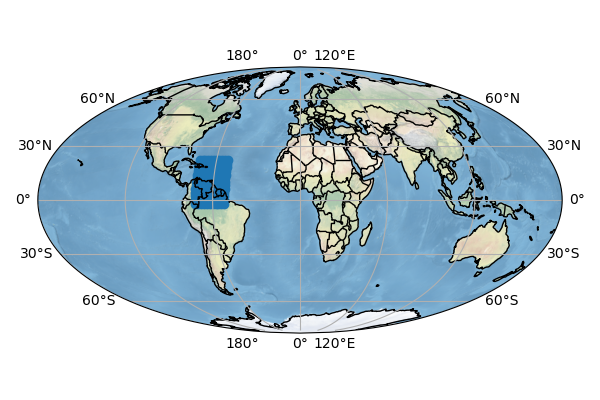

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

n_ev = 10 # number of events

intensity = sparse.csr_matrix(np.random.random((n_ev, centroids.size)) * 20)
fraction = intensity.copy()
fraction.data.fill(1)


try:
    haz = load_from_cache('haz')
except FileNotFoundError:
    haz = Hazard('TC',
                 centroids=centroids,
                 intensity=intensity,
                 fraction=fraction,
                 units='m/s',
                 event_id=np.arange(n_ev, dtype=int),
                 event_name=['ev_12', 'ev_21', 'Maria', 'ev_35',
                             'Irma', 'ev_16', 'ev_15', 'Edgar', 'ev_1', 'ev_9'],
                 date=np.array([1, 380, 450, 1200, 1500,
                                1800, 2020, 2580, 3400, 3600]),
                 orig=np.zeros(n_ev, bool),
                 frequency=np.ones(n_ev)/10,)
    haz.check()
    save_to_cache('haz', haz)



import ipywidgets as widgets
import cartopy.crs as ccrs
import ipympl

plt.ion()

out = widgets.Output(layout=dict(width='90%'))

with out:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(projection=ccrs.Mollweide())
    ax.stock_img()
    
    haz.centroids.plot(axis=ax)
    plt.tight_layout();

```python
haz.plot_rp_intensity(return_periods=(1, 2, 5))
```

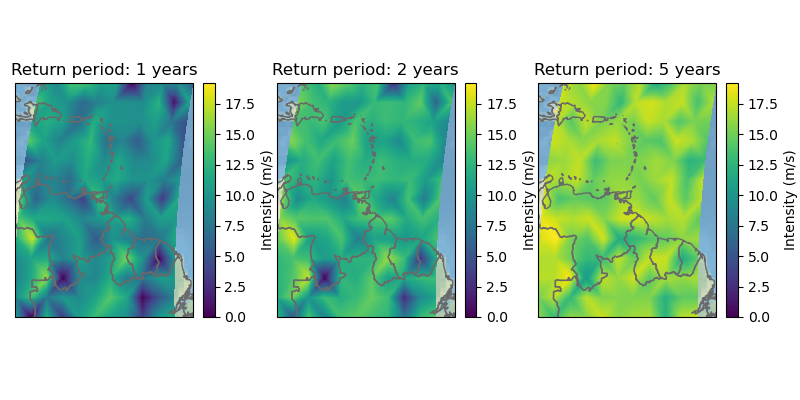

In [6]:
fig = plt.figure(figsize=(8,4))
axes = fig.subplots(1, 3, subplot_kw=dict(projection=ccrs.Mollweide()))
for ax in axes:
    ax.stock_img()

haz.plot_rp_intensity(axis=axes, return_periods=(1, 2, 5));

```python
haz.local_return_period([5, 10])[0]
```

In [13]:
haz.local_return_period([5, 10])[0]

,geometry,5,10
0,POINT (-72.00000 22.00000),1.250000,1.428571
1,POINT (-70.00000 22.00000),1.666667,1.666667
2,POINT (-68.00000 22.00000),1.111111,1.250000
3,POINT (-66.00000 22.00000),3.333333,5.000000
4,POINT (-64.00000 22.00000),1.111111,2.500000
...,...,...,...
138,POINT (-60.00000 -2.00000),1.111111,1.250000
139,POINT (-58.00000 -2.00000),1.428571,1.428571
140,POINT (-56.00000 -2.00000),1.250000,3.333333
141,POINT (-54.00000 -2.00000),1.666667,2.000000


## Now with real data 😎

Here we will work with real historical data of Tropical Cyclones. First we need to obtain these data.

In [15]:
import numpy as np
from climada.hazard import TCTracks

try:
    tracks_1900_2020 = load_from_cache('tracks_1900_2020')
    tracks_2017 = load_from_cache('tracks_2017')
except FileNotFoundError:
    tracks_1900_2020 = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range = (1900, 2020))
    tracks_2017 = TCTracks.from_ibtracs_netcdf(provider='usa', basin='NA', year_range = (2017, 2018))
    save_to_cache('tracks_1900_2020', tracks_1900_2020)
    save_to_cache('tracks_2017', tracks_2017)
    
tracks_2017.data[0]

<xarray.Dataset> Size: 3kB
Dimensions:                 (time: 53)
Coordinates:
  * time                    (time) datetime64[ns] 424B 2017-04-16T06:00:00 .....
    lat                     (time) float32 212B 35.8 35.45 35.1 ... 32.25 31.9
    lon                     (time) float32 212B -50.3 -49.9 ... -47.65 -46.4
Data variables:
    radius_max_wind         (time) float32 212B 150.0 150.0 150.0 ... 40.0 40.0
    radius_oci              (time) float32 212B 330.0 330.0 ... 400.0 400.0
    max_sustained_wind      (time) float32 212B 55.0 55.0 55.0 ... 32.0 30.0
    central_pressure        (time) float32 212B 992.0 990.0 ... 1e+03 1.001e+03
    environmental_pressure  (time) float64 424B 1.012e+03 1.012e+03 ... 1.01e+03
    time_step               (time) float64 424B 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    basin                   (time) <U2 424B 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
Attributes:
    max_sustained_wind_unit:  kn
    central_pressure_unit:    mb
    orig_event_flag:          True
    data_provider:            ibtracs_usa
    category:                 0
    name:                     ARLENE
    sid:                      2017106N36310
    id_no:                    2017106036310.0

We can also plot the tracks of the Tropical Cyclones from 2017.

```python
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.stock_img()

tracks_2017.plot(axis=ax);
```

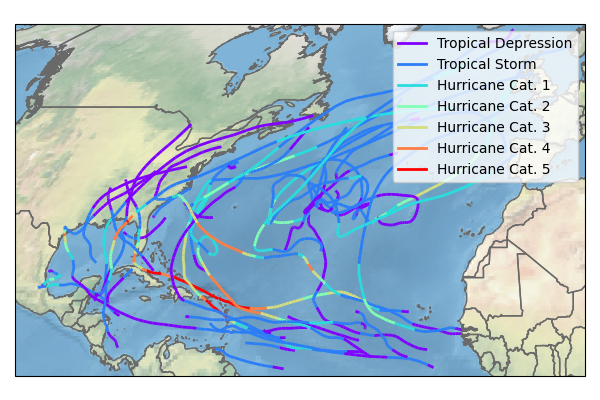

In [16]:
plt.ion()

out = widgets.Output(layout=dict(width='90%'))

with out:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(projection=ccrs.Mollweide())
    ax.stock_img()
    
    tracks_2017.plot(axis=ax);

Let's define the centroids for our hazard.

Output(layout=Layout(width='90%'))

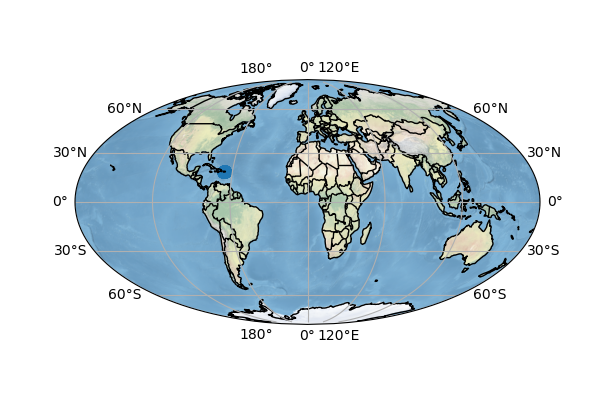

In [17]:
%matplotlib widget

from climada.hazard import Centroids
import matplotlib.pyplot as plt

try:
    cent = load_from_cache('cent2')
except FileNotFoundError:
    min_lat, max_lat, min_lon, max_lon = 17.5, 19.0, -68.0, -65.0
    cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.1)
    save_to_cache('cent2', cent)

import ipywidgets as widgets
import cartopy.crs as ccrs

out = widgets.Output(layout=dict(width='90%'))
with out:
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(projection=ccrs.Mollweide())
    ax.stock_img()
    
    cent.plot(axis=ax);
out

Now we need to map intensities from the TC tracks dataset to our centroids. Thankfully, there is already a method of the TropCyclone class (which inherits from the Hazard class) to achieve this.

```python
from climada.hazard import TropCyclone
haz = TropCyclone.from_tracks(tracks_2000_2020, centroids=cent)
```

In [18]:
from climada.hazard import TropCyclone, Hazard

try:
    haz = Hazard.from_hdf5('results/TChazard_hr.hdf5')
except FileNotFoundError as e:
    haz = TropCyclone.from_tracks(tracks_1900_2020, centroids=cent)
    haz.check()
    # we save the hazard for future use, as it is computationally heavy
    haz.write_hdf5('results/TChazard_hr.hdf5')

Now that we created our Hazard object, we can use its method, for instance to plot return period intensities.

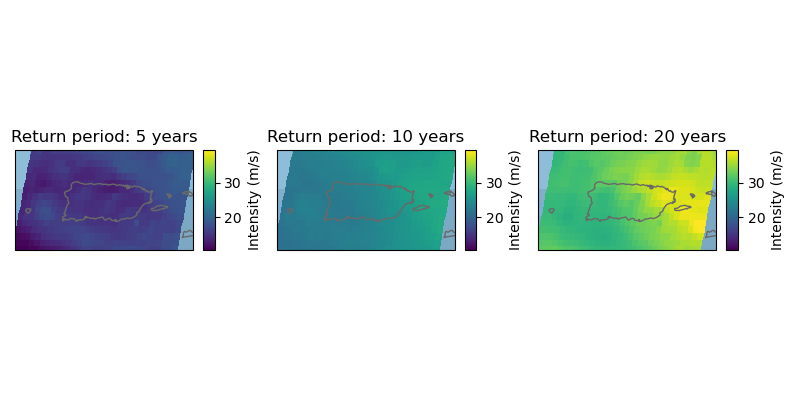

In [19]:
fig = plt.figure(figsize=(8,4))
axes = fig.subplots(1, 3, subplot_kw=dict(projection=ccrs.Mollweide()))
for ax in axes:
    ax.stock_img()

haz.plot_rp_intensity(axis=axes, return_periods=(5, 10, 20), smooth=False);

## Definition of Return Period and Return Level 

In this section, we introduce two notions that are key to climate risk analytics: Return Periods and Return Levels. These two notions express a relationship between the intensity of events and their frequency of occurence. Naturally, events with a greater intensity are less likely to occur. 

### Return period

<div class="alert alert-block alert-success">
<b>Definition:</b> For a given intensity $I$, the return period is the period T expressed in years such that the probability of observing an event with intensity greater than $I$ in a given year is $\frac{1}{T}$.

<p>An event with a Return Period $T$ is called a T-year event. For instance, we will say "a 100-year flood".</p>

<p>Another interpretation of the return period is that it is the expected number of years until an event
of a given intensity.</p>
</div>

For instance, if we say that a Tropical Cyclone with intensity $I=50 m/s$ has Return Period 10 years, it means that in a given year, the probability of a cyclone of intensity at least $50 m/s$ is 0.1

<div class="alert alert-block alert-danger">
<b>Common mistakes:</b> 
<ul>
    <li>A 10-year event does not necessarily occur once in a 10-year period. </li>
    <li>A 10-year event might occur twice in 2 years. But it might as well not occur over 50 years.</li>
</div>

### Exercise

What is the probability that a 10-year event occurs:
1. In a one-year period?
2. In a two-year period?
3. In a 10-year period?

### Return Level

<div class="alert alert-block alert-success">
<b>Definition:</b> For a given return period $T$, the return intensity or return level is the intensity $I$ such that the probability of observing an event with intensity $I$ is $\frac{1}{T}$.
</div>